In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
import os
import json
from pathlib import Path
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')


[Dataset source](https://doi.org/10.1038/s41597-024-03656-8)

In [16]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)


In [17]:
DATA_ROOT = "../raw_data/Data_YOLO"
TRAIN_IMAGES = f"{DATA_ROOT}/images/train"
TRAIN_LABELS = f"{DATA_ROOT}/labels/train"
VAL_IMAGES = f"{DATA_ROOT}/images/val"
VAL_LABELS = f"{DATA_ROOT}/labels/val"

# Class names for PCB defects taken from paper section Methods/Defect labeling and dataset partition
CLASS_NAMES = {
    0: "SH",      # Short
    1: "SP",      # Spur
    2: "SC",      # Spurious Copper
    3: "OP",      # Open 
    4: "MB",      # Mouse Bite
    5: "HB",      # Hole Breakout
    6: "CS",      # Conductor Scratch
    7: "CFO",     # Conductor Foreign Object
    8: "BMFO"     # Base Material Foreign Object
}

# Count total files
print(f"Dataset Root: {DATA_ROOT}\n")
train_img_count = len([f for f in os.listdir(TRAIN_IMAGES) if f.endswith(('.jpg', '.png'))])
val_img_count = len([f for f in os.listdir(VAL_IMAGES) if f.endswith(('.jpg', '.png'))])
train_lbl_count = len([f for f in os.listdir(TRAIN_LABELS) if f.endswith('.txt')])
val_lbl_count = len([f for f in os.listdir(VAL_LABELS) if f.endswith('.txt')])

print(f"\nTotal Images: {train_img_count + val_img_count} files")
print(f"Total Labels: {train_lbl_count + val_lbl_count} files")



Dataset Root: ../raw_data/Data_YOLO


Total Images: 10259 files
Total Labels: 10259 files


## Dataset Structure & YOLO Format

### Raw Data Organization
Our dataset consists of:
- **Images**: JPG files of PCB boards (10,259 total)
  - Training set: `images/train/` (8,208 images)
  - Validation set: `images/val/` (2,051 images)
- **Labels**: TXT files with bounding box annotations (one per image)
  - Training labels: `labels/train/`
  - Validation labels: `labels/val/`

Each label file (`.txt`) contains one line per defect with the format:
```
class_id center_x center_y width height
```

**All coordinates are normalized (0-1) relative to image dimensions:**
- `class_id`: Integer representing defect type (0-8)
- `center_x`: X-coordinate of bounding box center (0 = left edge, 1 = right edge)
- `center_y`: Y-coordinate of bounding box center (0 = top edge, 1 = bottom edge)
- `width`: Bounding box width as fraction of image width
- `height`: Bounding box height as fraction of image height

**Example:**
```
1 0.6283 0.5155 0.4779 0.0752
```
This represents a defect of class 1 (SP - Spur) with its center at (62.83%, 51.55%) of the image, spanning 47.79% width and 7.52% height.


In [18]:
def parse_yolo_labels(labels_dir):
    """
    Parse YOLO format labels and extract statistics.
    YOLO format: class_id center_x center_y width height (all normalized 0-1)
    """
    annotations = []
    
    for label_file in os.listdir(labels_dir):
        if not label_file.endswith('.txt'):
            continue
            
        label_path = os.path.join(labels_dir, label_file)
        
        with open(label_path, 'r') as f:
            lines = f.readlines()
            
        for line in lines:
            if line.strip():
                parts = line.strip().split()
                class_id = int(parts[0])
                center_x = float(parts[1])
                center_y = float(parts[2])
                width = float(parts[3])
                height = float(parts[4])
                
                annotations.append({
                    'filename': label_file.replace('.txt', '.jpg'),
                    'class_id': class_id,
                    'class_name': CLASS_NAMES.get(class_id, f"class_{class_id}"),
                    'center_x': center_x,
                    'center_y': center_y,
                    'bbox_width': width,
                    'bbox_height': height,
                    'bbox_area': width * height
                })
    
    return pd.DataFrame(annotations)


In [19]:
train_annotations = parse_yolo_labels(TRAIN_LABELS)
train_annotations['split'] = 'train'
val_annotations = parse_yolo_labels(VAL_LABELS)
val_annotations['split'] = 'val'

all_annotations = pd.concat([train_annotations, val_annotations], ignore_index=True)

print(f"\n Total: {len(all_annotations)} annotations from {len(all_annotations['filename'].unique())} images")
print(f"\nDataset Overview:")
print(all_annotations.head())


 Total: 20276 annotations from 10259 images

Dataset Overview:
      filename  class_id class_name  center_x  center_y  bbox_width  \
0  0003730.jpg         1         SP    0.6283    0.5155      0.4779   
1  0003730.jpg         1         SP    0.3363    0.5376      0.1416   
2  0003759.jpg         0         SH    0.5664    0.4912      0.1327   
3  0003759.jpg         5         HB    0.4646    0.5752      0.1858   
4  0004469.jpg         1         SP    0.4248    0.5022      0.2655   

   bbox_height  bbox_area  split  
0       0.0752   0.035938  train  
1       0.0398   0.005636  train  
2       0.1327   0.017609  train  
3       0.1858   0.034522  train  
4       0.1106   0.029364  train  


## CLASS DISTRIBUTION ANALYSIS


 Overall Class Distribution:
class_name
SP      4584
HB      2883
MB      2529
CS      2490
CFO     1832
OP      1770
BMFO    1680
SC      1593
SH       915
Name: count, dtype: int64


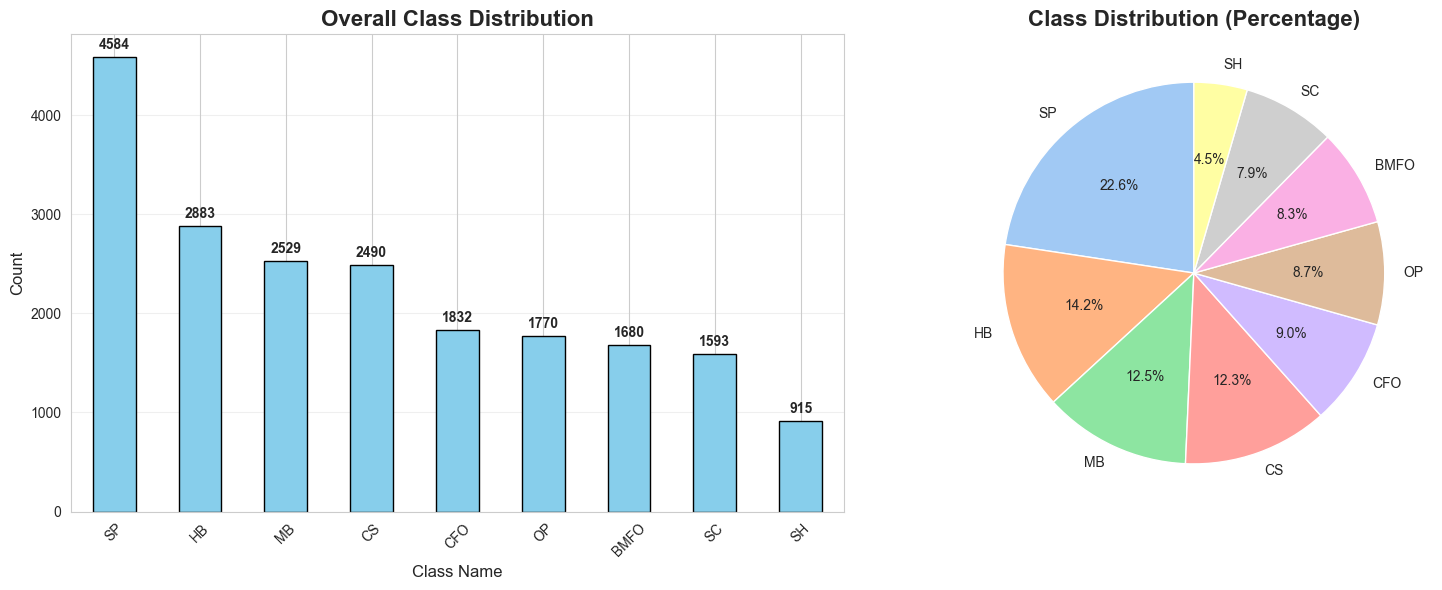

Most common class: SP (4584 samples)
Least common class: SH (915 samples)
Imbalance ratio: 5.01:1


In [24]:
# Overall class distribution
class_counts = all_annotations['class_name'].value_counts()
print("\n Overall Class Distribution:")
print(class_counts)

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Overall distribution - Bar chart
ax1 = axes[0]
class_counts.plot(kind='bar', ax=ax1, color='skyblue', edgecolor='black')
ax1.set_title('Overall Class Distribution', fontsize=16, fontweight='bold')
ax1.set_xlabel('Class Name', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(class_counts):
    ax1.text(i, v + 50, str(v), ha='center', va='bottom', fontweight='bold')

# Pie chart showing percentage distribution
ax2 = axes[1]
class_counts.plot(kind='pie', ax=ax2, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
ax2.set_title('Class Distribution (Percentage)', fontsize=16, fontweight='bold')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

# Class imbalance analysis
max_count = class_counts.max()
min_count = class_counts.min()
imbalance_ratio = max_count / min_count
print(f"Most common class: {class_counts.index[0]} ({class_counts.iloc[0]} samples)")
print(f"Least common class: {class_counts.index[-1]} ({class_counts.iloc[-1]} samples)")
print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")


BOUNDING BOX STATISTICS

Bounding Box Dimensions (normalized):

Width statistics:
count    20276.000000
mean         0.148582
std          0.168407
min          0.008800
25%          0.057500
50%          0.092900
75%          0.177000
max          1.000000
Name: bbox_width, dtype: float64

Height statistics:
count    20276.000000
mean         0.140628
std          0.152249
min          0.008800
25%          0.053100
50%          0.088500
75%          0.177000
max          1.000000
Name: bbox_height, dtype: float64

Area statistics:
count    20276.000000
mean         0.038508
std          0.109381
min          0.000350
25%          0.003287
50%          0.008142
75%          0.029695
max          1.000000
Name: bbox_area, dtype: float64

Objects per Image Statistics:
count    10259.000000
mean         1.976411
std          1.863553
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         27.000000
Name: count, dtype: float64


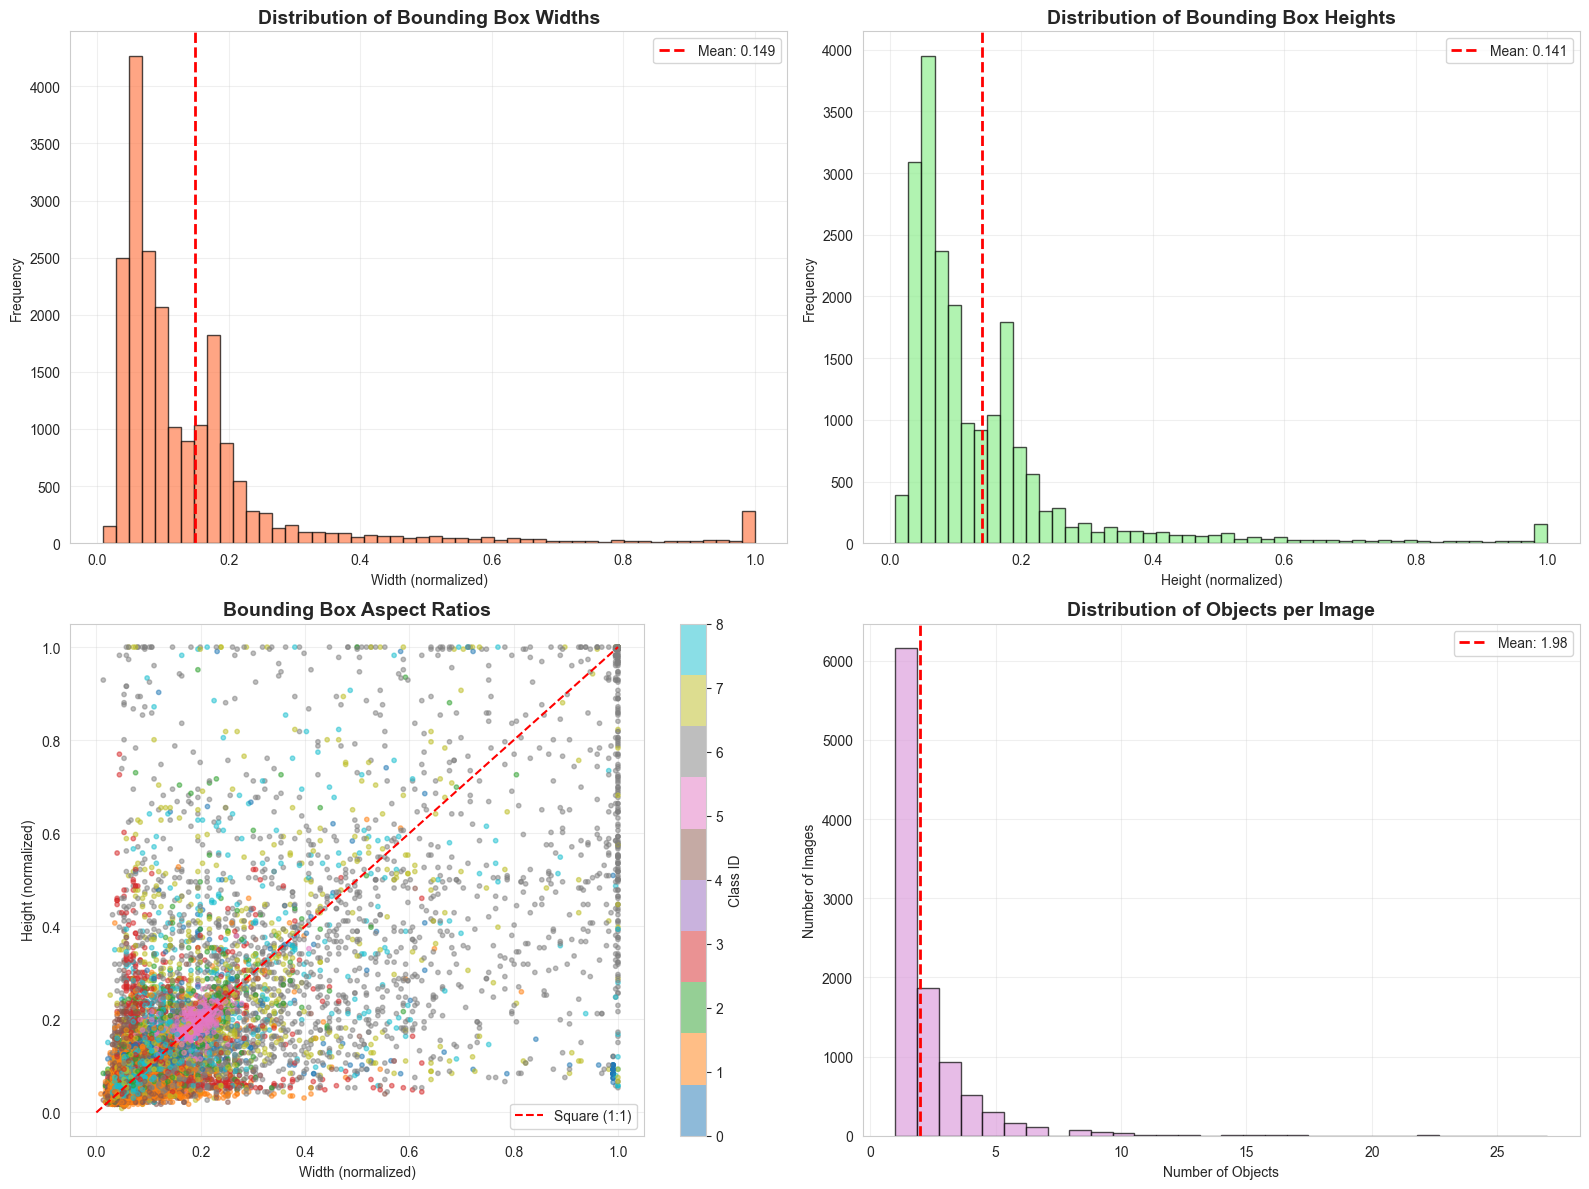


Additional Statistics:
Images with single defect: 6157
Images with multiple defects: 4102
Max defects in single image: 27


In [25]:
# BOUNDING BOX STATISTICS
print("="*60)
print("BOUNDING BOX STATISTICS")
print("="*60)

# Basic statistics
print("\nBounding Box Dimensions (normalized):")
print("\nWidth statistics:")
print(all_annotations['bbox_width'].describe())
print("\nHeight statistics:")
print(all_annotations['bbox_height'].describe())
print("\nArea statistics:")
print(all_annotations['bbox_area'].describe())

# Objects per image
objects_per_image = all_annotations.groupby('filename').size().reset_index(name='count')
print(f"\nObjects per Image Statistics:")
print(objects_per_image['count'].describe())

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribution of bbox widths
ax1 = axes[0, 0]
all_annotations['bbox_width'].hist(bins=50, ax=ax1, color='coral', edgecolor='black', alpha=0.7)
ax1.set_title('Distribution of Bounding Box Widths', fontsize=14, fontweight='bold')
ax1.set_xlabel('Width (normalized)')
ax1.set_ylabel('Frequency')
ax1.axvline(all_annotations['bbox_width'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {all_annotations['bbox_width'].mean():.3f}")
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Distribution of bbox heights
ax2 = axes[0, 1]
all_annotations['bbox_height'].hist(bins=50, ax=ax2, color='lightgreen', edgecolor='black', alpha=0.7)
ax2.set_title('Distribution of Bounding Box Heights', fontsize=14, fontweight='bold')
ax2.set_xlabel('Height (normalized)')
ax2.set_ylabel('Frequency')
ax2.axvline(all_annotations['bbox_height'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {all_annotations['bbox_height'].mean():.3f}")
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Width vs Height scatter
ax3 = axes[1, 0]
scatter = ax3.scatter(all_annotations['bbox_width'], all_annotations['bbox_height'], 
                     c=all_annotations['class_id'], cmap='tab10', alpha=0.5, s=10)
ax3.set_title('Bounding Box Aspect Ratios', fontsize=14, fontweight='bold')
ax3.set_xlabel('Width (normalized)')
ax3.set_ylabel('Height (normalized)')
ax3.plot([0, 1], [0, 1], 'r--', label='Square (1:1)')
ax3.legend()
ax3.grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax3)
cbar.set_label('Class ID')

# 4. Objects per image distribution
ax4 = axes[1, 1]
objects_per_image['count'].hist(bins=30, ax=ax4, color='plum', edgecolor='black', alpha=0.7)
ax4.set_title('Distribution of Objects per Image', fontsize=14, fontweight='bold')
ax4.set_xlabel('Number of Objects')
ax4.set_ylabel('Number of Images')
ax4.axvline(objects_per_image['count'].mean(), color='red', linestyle='--', linewidth=2, 
           label=f"Mean: {objects_per_image['count'].mean():.2f}")
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Additional statistics
print(f"\nAdditional Statistics:")
print(f"Images with single defect: {len(objects_per_image[objects_per_image['count'] == 1])}")
print(f"Images with multiple defects: {len(objects_per_image[objects_per_image['count'] > 1])}")
print(f"Max defects in single image: {objects_per_image['count'].max()}")


SAMPLE IMAGES WITH ANNOTATIONS


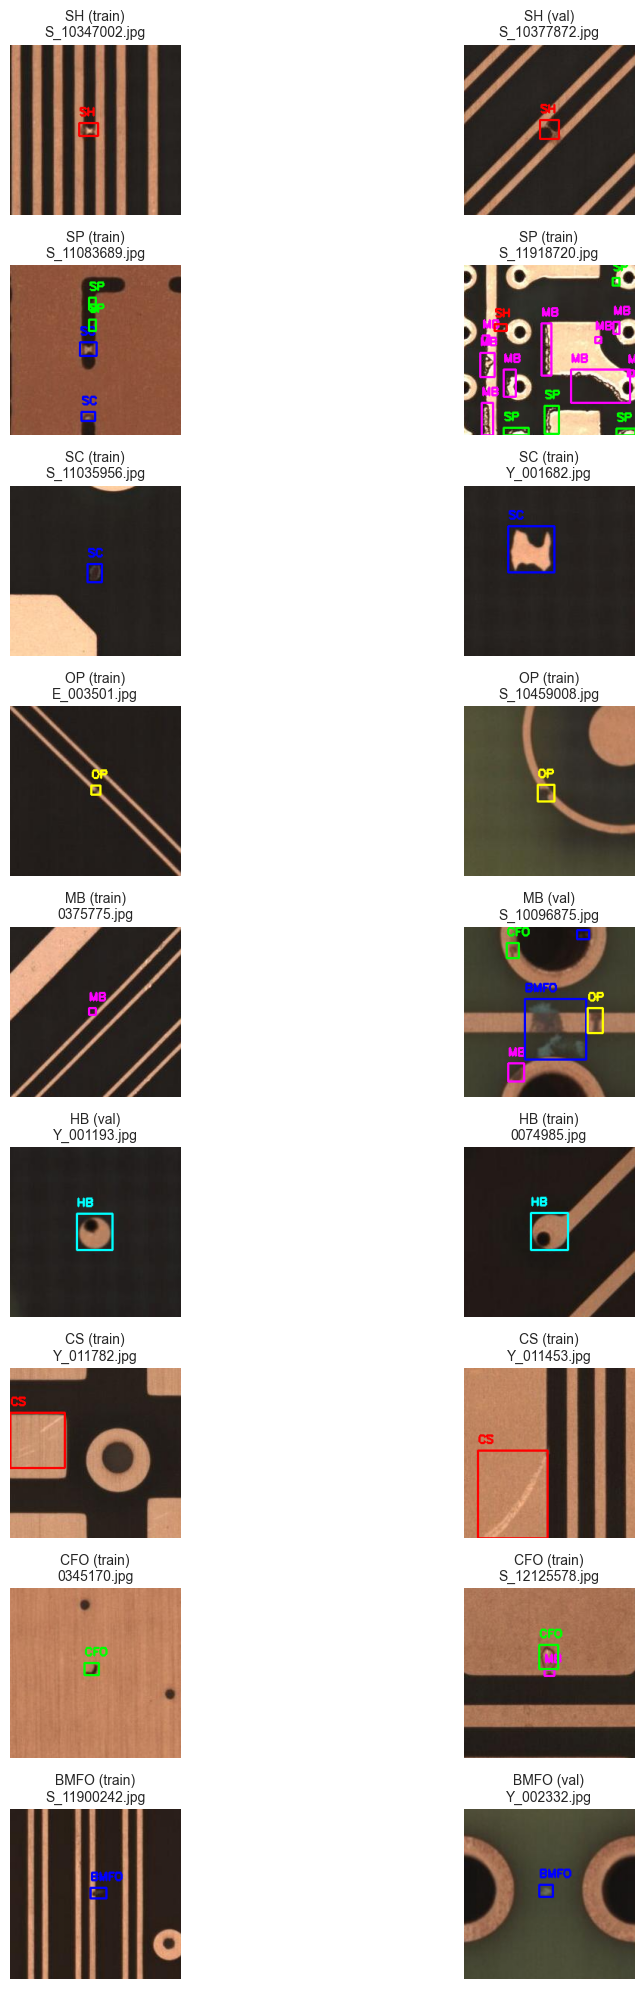

In [27]:
# VISUALIZE SAMPLE IMAGES WITH ANNOTATIONS
print("="*60)
print("SAMPLE IMAGES WITH ANNOTATIONS")
print("="*60)

def draw_yolo_boxes(image_path, label_path, class_names):
    """
    Draw bounding boxes on image from YOLO format labels
    """
    # Read image
    img = cv.imread(image_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    
    # Read labels
    if not os.path.exists(label_path):
        return img
    
    with open(label_path, 'r') as f:
        lines = f.readlines()
    
    # Define colors for each class (RGB)
    colors = [
        (255, 0, 0), (0, 255, 0), (0, 0, 255),
        (255, 255, 0), (255, 0, 255), (0, 255, 255)
    ]
    
    for line in lines:
        if line.strip():
            parts = line.strip().split()
            class_id = int(parts[0])
            center_x = float(parts[1]) * w
            center_y = float(parts[2]) * h
            bbox_w = float(parts[3]) * w
            bbox_h = float(parts[4]) * h
            
            # Convert to corner coordinates
            x1 = int(center_x - bbox_w / 2)
            y1 = int(center_y - bbox_h / 2)
            x2 = int(center_x + bbox_w / 2)
            y2 = int(center_y + bbox_h / 2)
            
            # Draw rectangle
            color = colors[class_id % len(colors)]
            cv.rectangle(img, (x1, y1), (x2, y2), color, 2)
            
            # Draw label
            label = class_names.get(class_id, f"Class {class_id}")
            cv.putText(img, label, (x1, y1-10), cv.FONT_HERSHEY_SIMPLEX, 
                      0.5, color, 2)
    
    return img

# Sample images from each class
samples_per_class = 2
fig, axes = plt.subplots(len(CLASS_NAMES), samples_per_class, figsize=(12, 20))

for idx, (class_id, class_name) in enumerate(CLASS_NAMES.items()):
    # Get samples for this class with split information
    class_samples_df = all_annotations[all_annotations['class_id'] == class_id][['filename', 'split']].drop_duplicates()
    
    if len(class_samples_df) > 0:
        # Take up to samples_per_class samples
        selected_indices = np.random.choice(len(class_samples_df), 
                                           min(samples_per_class, len(class_samples_df)), 
                                           replace=False)
        selected_samples = class_samples_df.iloc[selected_indices]
        
        for col, (_, row) in enumerate(selected_samples.iterrows()):
            filename = row['filename']
            split = row['split']
            
            # Get image and label paths based on split
            if split == 'train':
                img_path = os.path.join(TRAIN_IMAGES, filename)
                lbl_path = os.path.join(TRAIN_LABELS, filename.replace('.jpg', '.txt'))
            else:
                img_path = os.path.join(VAL_IMAGES, filename)
                lbl_path = os.path.join(VAL_LABELS, filename.replace('.jpg', '.txt'))
            
            # Draw boxes
            img_with_boxes = draw_yolo_boxes(img_path, lbl_path, CLASS_NAMES)
            
            # Display
            ax = axes[idx, col] if samples_per_class > 1 else axes[idx]
            ax.imshow(img_with_boxes)
            ax.set_title(f"{class_name} ({split})\n{filename}", fontsize=10)
            ax.axis('off')
    
plt.tight_layout()
plt.show()